Trabalhando com séries temporais

In [28]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from prophet import Prophet

O Prophet é uma ferramenta desenvolvida pelo Facebook para fazer previsões em séries temporais, que são basicamente dados coletados ao longo do tempo, como os preços das ações. É famoso por ser fácil de usar e por funcionar bem mesmo com poucos dados ou com dados que possuem padrões irregulares, o que é comum no mercado de ações.

Vamos usar dados de ações da empresa Johnson & Johnson como exemplo.

Aqui, usamos um comando para baixar os dados. É como se estivéssemos pedindo à internet para nos dar os preços das ações da Johnson & Johnson desde 2020 até o final de 2023. Fácil, né?

In [29]:
# Baixar dados dos últimos quatro anos para uma ação específica
dados = yf.download("JNJ", start="2020-01-01", end="2023-12-31", progress=False)  # progess = False não aparece o progresso de download (seria legal deixar True)
dados = dados.reset_index()
dados

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,145.869995,146.020004,145.080002,145.970001,130.099106,5777000
1,2020-01-03,143.500000,145.369995,143.000000,144.279999,128.592865,5752400
2,2020-01-06,144.000000,144.199997,142.850006,144.100006,128.432419,7731300
3,2020-01-07,144.009995,145.449997,141.380005,144.979996,129.216797,7382900
4,2020-01-08,144.869995,145.979996,143.699997,144.960007,129.198929,6605800
...,...,...,...,...,...,...,...
1001,2023-12-22,155.250000,156.529999,155.020004,155.460007,154.288544,3798500
1002,2023-12-26,155.000000,156.350006,154.850006,156.139999,154.963409,4170000
1003,2023-12-27,155.500000,156.520004,155.419998,156.350006,155.171844,5288100
1004,2023-12-28,156.000000,157.240005,155.990005,156.580002,155.400101,4377500


Realizar previsão com os dados do DF.

Guardar em variável dados de treino e dados de teste


In [30]:
# Vamos dividir os dados em treino (até o final do primeiro semestre de 2023) e teste (segundo semestre de 2023)
dados_treino = dados[dados['Date'] < '2023-07-31']
dados_teste = dados[dados['Date'] >= '2023-07-31']


In [31]:
# Se quiser, use essa célula para ver as varáveis dados_teste, dados_treino
dados_teste

,Date,Open,High,Low,Close,Adj Close,Volume
899,2023-07-31,169.690002,170.220001,166.710007,167.529999,163.757721,22632700
900,2023-08-01,166.369995,169.089996,166.059998,168.889999,165.087097,15810300
901,2023-08-02,168.850006,171.240005,168.850006,169.910004,166.084137,14595600
902,2023-08-03,169.949997,171.320007,169.669998,170.639999,166.797699,17424800
903,2023-08-04,170.339996,172.679993,167.889999,169.039993,165.233719,23414300
...,...,...,...,...,...,...,...
1001,2023-12-22,155.250000,156.529999,155.020004,155.460007,154.288544,3798500
1002,2023-12-26,155.000000,156.350006,154.850006,156.139999,154.963409,4170000
1003,2023-12-27,155.500000,156.520004,155.419998,156.350006,155.171844,5288100
1004,2023-12-28,156.000000,157.240005,155.990005,156.580002,155.400101,4377500


In [32]:
# Preparando os dados para o FBProphet

# Criar nova df com as colunas Date e Close do df original, renomear para ds e y (a biblioteca trabalha com esses nomes)
dados_prophet_treino = dados_treino[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
dados_prophet_treino

,ds,y
0,2020-01-02,145.970001
1,2020-01-03,144.279999
2,2020-01-06,144.100006
3,2020-01-07,144.979996
4,2020-01-08,144.960007
...,...,...
894,2023-07-24,171.080002
895,2023-07-25,172.389999
896,2023-07-26,172.720001
897,2023-07-27,173.690002


O próximo passo é preparar os dados para o nosso adivinho, o Prophet. É como se estivéssemos arrumando os dados para que ele entenda o que estamos perguntando.

Depois, criamos o modelo do Prophet. Aqui, estamos dizendo ao Prophet para considerar padrões semanais e anuais nos dados, mas não diários. E também adicionamos feriados dos EUA, já que eles podem influenciar o preço das ações.

**Abaixo será apresentado para alguns parâmetros, vou tentar explicar aqui:**

`weekly_seasonality=True:`

* Este parâmetro ativa a modelagem da sazonalidade semanal no Prophet. Isso significa que o modelo tentará capturar padrões que se repetem semanalmente nos dados. Por exemplo, se você estiver trabalhando com dados de vendas de varejo, é comum que haja flutuações nas vendas durante a semana (como picos nos fins de semana e diminuições nos dias úteis). Ativando essa sazonalidade semanal, o modelo tentará ajustar essas flutuações sazonais.

`yearly_seasonality=True:`

* Esse parâmetro ativa a modelagem da sazonalidade anual. Ele é útil quando seus dados possuem padrões sazonais que ocorrem em intervalos de um ano. Por exemplo, se você está analisando dados de vendas ao longo do tempo e espera ver aumentos nas vendas durante certas estações do ano (como vendas de roupas de inverno aumentando no inverno), ativar essa sazonalidade ajudará o modelo a capturar esses padrões anuais.

`daily_seasonality=False:`

* Este parâmetro desativa a modelagem da sazonalidade diária. Normalmente, a sazonalidade diária é relevante para dados que têm padrões que se repetem a cada dia, como padrões de tráfego na web, demanda de energia elétrica ao longo do dia, etc. Desativar essa sazonalidade significa que o modelo não tentará ajustar padrões que ocorrem diariamente nos dados. Dependendo dos seus dados, pode ser útil ativar ou desativar essa sazonalidade.

Entenda sazonalidade por variação de dados naquele intervalo de temporal (anual, diário, mensal)

In [33]:
# Criar e treinar o modelo
modelo = Prophet(weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=True)


# Adicionar os feriados de determinado país (nesse caso americano (US))
modelo.add_country_holidays(country_name='US')

# fit é a função de aprendizagem. Só rodar
modelo.fit(dados_prophet_treino)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1kdwkto_/p75g2utp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1kdwkto_/ur_7zlzs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71241', 'data', 'file=/tmp/tmp1kdwkto_/p75g2utp.json', 'init=/tmp/tmp1kdwkto_/ur_7zlzs.json', 'output', 'file=/tmp/tmp1kdwkto_/prophet_modelscv1_t7u/prophet_model-20240329165748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:57:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:57:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


O próximo código vamos prever o 'futuro' com o modelo-treino.

In [34]:
# Criar datas futuras para previsão até o final de 2023

# Calcular no futuro (150 dias?)
futuro = modelo.make_future_dataframe(periods=150)

# Código de previsão
previsao = modelo.predict(futuro)

In [35]:
previsao

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-02,145.085378,145.044496,155.790813,145.085378,145.085378,0.0,0.0,0.0,0.0,...,0.079957,0.079957,0.079957,4.225676,4.225676,4.225676,0.0,0.0,0.0,150.296143
1,2020-01-03,145.068997,145.174434,155.542783,145.068997,145.068997,0.0,0.0,0.0,0.0,...,0.219033,0.219033,0.219033,4.025687,4.025687,4.025687,0.0,0.0,0.0,150.218849
2,2020-01-06,145.019856,143.668875,154.250960,145.019856,145.019856,0.0,0.0,0.0,0.0,...,-0.184895,-0.184895,-0.184895,3.383184,3.383184,3.383184,0.0,0.0,0.0,149.123277
3,2020-01-07,145.003476,143.903261,154.667567,145.003476,145.003476,0.0,0.0,0.0,0.0,...,-0.016263,-0.016263,-0.016263,3.169304,3.169304,3.169304,0.0,0.0,0.0,149.061649
4,2020-01-08,144.987096,143.566643,154.117509,144.987096,144.987096,0.0,0.0,0.0,0.0,...,0.128451,0.128451,0.128451,2.962556,2.962556,2.962556,0.0,0.0,0.0,148.983234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,2023-12-21,149.301752,144.804176,165.806990,140.192666,158.996718,0.0,0.0,0.0,0.0,...,0.079957,0.079957,0.079957,4.699009,4.699009,4.699009,0.0,0.0,0.0,154.985850
1045,2023-12-22,149.250163,144.634037,167.068283,140.026319,159.024381,0.0,0.0,0.0,0.0,...,0.219033,0.219033,0.219033,4.828522,4.828522,4.828522,0.0,0.0,0.0,155.202850
1046,2023-12-23,149.198573,144.776738,166.388608,139.804502,159.071374,0.0,0.0,0.0,0.0,...,-0.113141,-0.113141,-0.113141,4.927806,4.927806,4.927806,0.0,0.0,0.0,154.918370
1047,2023-12-24,149.146983,143.809544,166.039798,139.512285,159.096153,0.0,0.0,0.0,0.0,...,-0.113141,-0.113141,-0.113141,4.995307,4.995307,4.995307,0.0,0.0,0.0,154.934281


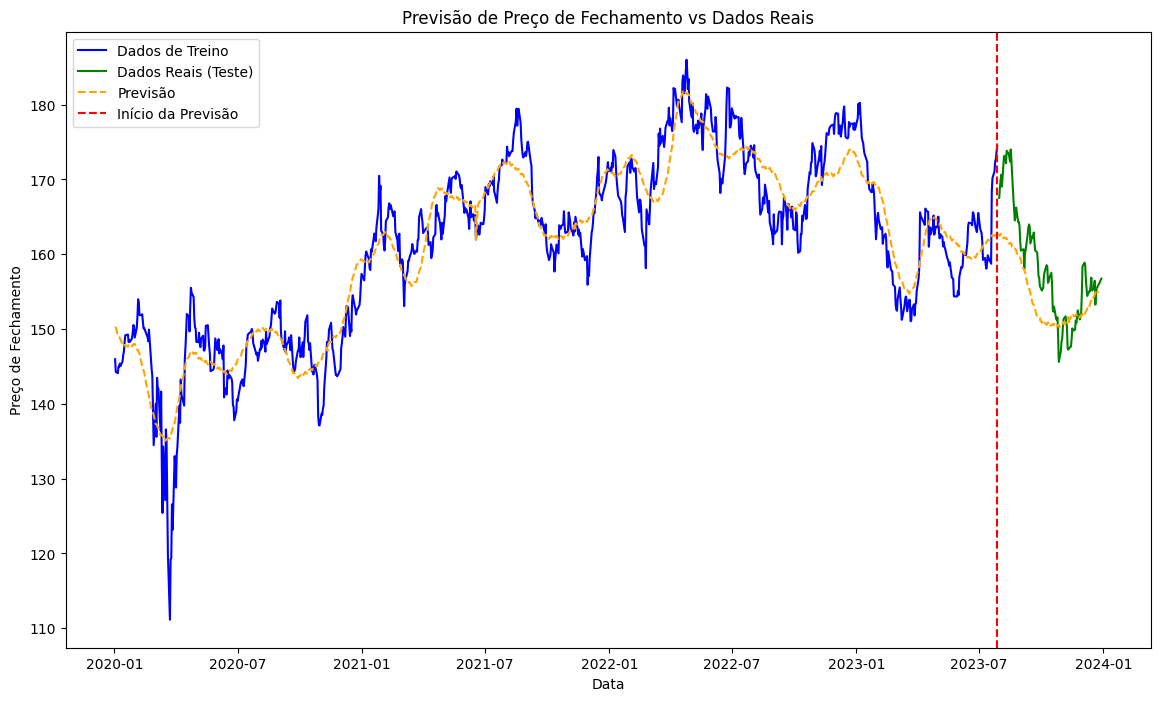

In [36]:
# Melhor visualização é com gráfico. COmparando a previsão (modelo om dados_treino) como dados_teste

plt.figure(figsize=(14, 8))
plt.plot(dados_treino['Date'], dados_treino['Close'], label='Dados de Treino', color='blue')
plt.plot(dados_teste['Date'], dados_teste['Close'], label='Dados Reais (Teste)', color='green')
plt.plot(previsao['ds'], previsao['yhat'], label='Previsão', color='orange', linestyle='--')

#Vizualizar a separação entre Treino e Dados Reais-Previsão
plt.axvline(dados_treino['Date'].max(), color='red', linestyle='--', label='Início da Previsão') # Uma linha vertical vermelha

plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title('Previsão de Preço de Fechamento vs Dados Reais')
plt.legend()  # Importante para informar as legendas das linhas
plt.show()